ДОМАШНЕЕ ЗАДАНИЕ 2. Выбор модели

Папулин С.Ю. (papulin.study@yandex.ru)

Цель работы
реализация собственных классов совместимых с библиотекой sklearn
использование полиномиальной транcформации в моделях регрессии и классификации
использование регуляризации в моделях регрессии и классификации
выбор гиперпараметров и интерпретация кривых обучения

**Вариант**

Чтобы узнать свой вариант, введите Вашу фамилию в соответствующее поле ниже и запустите ячейку:

In [ ]:
surname = "Малкина"  # Ваша фамилия

alph = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
w = [4, 42, 21, 21, 34,  1, 44, 26, 18, 43, 38, 26, 18, 43,  3, 49, 45,
        7, 42, 25,  4,  9, 36, 33, 31, 29,  5, 31,  4, 19, 24, 27, 33]
d = dict(zip(alph, w))
variant =  sum([d[el] for el in surname.lower()]) % 2 + 1
print("Ваш вариант - ", variant)

Ваш вариант -  2


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import (
    train_test_split,
    ShuffleSplit,
    KFold, 
    LeaveOneOut,
    StratifiedKFold,
    cross_val_score, 
    cross_validate
)

from sklearn.linear_model import (
    Ridge, RidgeCV, 
    LogisticRegression, LogisticRegressionCV, RidgeClassifier,LinearRegression)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.pipeline import Pipeline
from scipy.linalg import lstsq
from scipy import stats
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
import sys
import os
py_file_location = "/drive/my-drive"
sys.path.append(os.path.abspath(py_file_location))
from plot_utils import show_cplots



---


# Задание 1. Реализация собственных классов и функций
Набор данные





In [6]:
data = pd.read_csv("https://raw.githubusercontent.com/MLMethods/Assignments/master/data/A2_Model_Selection/Reg_A5.csv")
X = np.array(data[['X']])
y = np.array(data[['Y']])

⚠️ Замечание. 
1) Нельзя пользоваться готовыми реализациями sklearn;
2) чтобы избежать случай с вырожденной матрицей при оценке параметров используйте pinv из пакета numpy или добавьте небольшую регуляризацию.

Пункты:



1.   Реализуйте класс, предназначенный для оценки параметров линейной регрессии с регуляризацией совместимый с sklearn. Передаваемые параметры: 1) коэффициент регуляризации (alpha). Использовать метод наименьших квадратов с регуляризацией

In [2]:
class CustomLinearRegression(RegressorMixin, BaseEstimator):
  def __init__(self, method='ols'):
    self.method = method
  def fit(self, X, y, alpha=0.01):
    X, y = check_X_y(X, y)
    X_ = np.insert(X, 0, 1, axis=1)
    try:
      mas_diag_1 = np.eye(X_.shape[1])
      mas_diag_1[0][0] = 0
      intermediate = np.linalg.solve(X_.T @ X_+alpha*mas_diag_1, X_.T @ y)
      self.coef_0 = intermediate[0]
      self.coef_1 = intermediate[1:]
    except:
      raise ValueError
    return self
  def predict(self, X):
    check_is_fitted(self, 'coef_0')
    check_is_fitted(self, 'coef_1')
    return self.coef_1.dot(X.T)+self.coef_0 

In [3]:
from sklearn.utils.estimator_checks import check_estimator
from sklearn.base import is_regressor 
is_regressor(CustomLinearRegression())

True

2.   Реализуйте класс для стандартизации признаков в виде трансформации совместимый с sklearn. Передаваемые параметры: 1) has_bias (содержит ли матрица вектор единиц), 2) apply_mean (производить ли центровку)


In [4]:
import statistics 
class CustomStandardTransformer(RegressorMixin, BaseEstimator):
    
    def __init__(self,method='ols', has_bias = False, apply_mean=True):
      self.has_bias=has_bias
      self.apply_mean=apply_mean    
    def fit(self, X, y=None):
      self.mu = statistics.mean(X.flatten()) 
      self.sigma = statistics.stdev(X.flatten())
      return self
    
    def fit_transform(self,X, y=None):
      self.mu = statistics.mean(X.flatten()) 
      self.sigma = statistics.stdev(X.flatten())
      if self.has_bias:       
        X = X.pop(X.shape[1])
      if self.apply_mean:       
        self.x_stands = (X - self.mu)/self.sigma
      else:
        self.x_stands = (X - self.mu)
      return self.x_stands
        
    def transform(self, X):
      if self.has_bias:       
        X = X.pop(X.shape[1])
      if self.apply_mean:       
        self.x_stands = (X - self.mu)/self.sigma
      else:
        self.x_stands = (X - self.mu)
      return self.x_stands

3.   Использую класс Pipeline, выполнить обучение линейной регрессии для набора данных с коэффициентом регуляризации равным 0.01.


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
pipeline = Pipeline([
    ("Standard", CustomStandardTransformer()),
    ("Regression", CustomLinearRegression(method='gd'))
])
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.38831169273095534

In [17]:
#Для проверки(оригинальные классы)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
pipeline_test = Pipeline([
("standartizer", StandardScaler()),
("regressor", LinearRegression())
])
pipeline_test.fit(X_train, y_train)
pipeline_test.score(X_test, y_test)

0.311560557151067

4.   Реализуйте функции для расчета MSEи R^2при отложенной выборке ( run_holdout) и кросс-валидации ( run_cross_val). Для кросс-валидации використовуйте только класс KFold. Выходные значения должны быть MSEи R^2для обучающей и тестовой частей.

Код шаблона:

In [21]:
def run_holdout(model, X, y, train_size, random_state) -> dict:
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1-train_size, random_state=random_state)
    if model == None:
      model= LinearRegression()
    model.fit(x_train,y_train)
    y_pred = model.predict(x_train)
    mse_train =mean_squared_error(y_pred, y_train)
    r2_train = r2_score(y_pred,y_train)
    y_pred3 = model.predict(x_test)
    mse_test = mean_squared_error(y_pred3, y_test)
    r2_test = r2_score(y_pred3,y_test)
    scores = {'Train mse': mse_train,'Train R2':r2_train, 'Test mse': mse_test,'Test R2':r2_test}
    return scores

def run_cross_val(model, X, y, n_splits, shuffle, random_state) -> dict:

    kfold = KFold(n_splits, shuffle= shuffle, random_state=random_state)
    if model == None:
      model= LinearRegression()
    mse_train=[None]*n_splits
    r2_train = [None]*n_splits
    mse_test = [None]*n_splits
    r2_test = [None]*n_splits

    i = 0
    for train_idx, test_idx  in kfold.split(X):
      X_train_cv = X[train_idx]; X_test_cv = X[test_idx]
      y_train_cv = y[train_idx]; y_test_cv = y[test_idx]
      model.fit(X_train_cv, y_train_cv)
      y_train_pred = model.predict(X_train_cv)
      mse_train[i] = mean_squared_error(y_train_pred,y_train_cv)
      r2_train[i] = r2_score(y_train_cv,y_train_pred)
      y_test_pred = model.predict(X_test_cv)
      mse_test[i] = mean_squared_error(y_test_pred,y_test_cv)
      r2_test[i] = r2_score(y_test_cv,y_test_pred)
      i += 1

    scores = {'Train mse': np.mean(mse_train),'Train R2':np.mean(r2_train), 'Test mse': np.mean(mse_test),'Test R2':np.mean(r2_test)}

    return scores

5.   Выведите значения MSE и R^2, полученные посредством функций run_holdout и run_cross_val. Использовать следующие параметры:
  *   train_size=0.7,
  *   n_splits=4,
  *   shuffle=True,
  *   random_state=0

In [22]:
print(run_holdout(None, X, y, 0.7, 0))
print(run_cross_val(None, X, y, 4, True, 0))

{'Train mse': 0.5057164648757099, 'Train R2': -1.55570645902626, 'Test mse': 0.6913711830596497, 'Test R2': -2.4644662962669472}
{'Train mse': 0.5579909033130394, 'Train R2': 0.22757647386537494, 'Test mse': 0.5664658624984322, 'Test R2': 0.2181793311833142}


---


# Задание 2. Регрессия и кросс-валидация
Набор данные

⚠️ Замечание:

Используйте ранее реализованные классы и функции
Разбейте исходные данные на обучающее и тестовое подмножества в соотношении 70 на 30, random_state=0
Для выбора гиперпараметров используйте два подхода: 1) с отложенной выборкой, 2) с кросс-валидацией
Дано множество наблюдений (см. набор данных к заданию), модель - линейная регрессия (без регуляризации). Найти степень полинома с минимальной ошибкой на проверочном подмножестве, определить среднеквадратическую ошибку на тестовом подмножестве (степень полинома от 1 до 25). Сделать заключение о влиянии степени полинома регуляризации.

Построить:

диаграмму разброса исходных данных
график зависимости среднеквадратической ошибки (MSE) от степени полинома для обучающего и проверочного подмножеств
график зависимости коэффициента детерминации (R^2) от степени полинома для обучающего и проверочного подмножеств
функцию регрессии (наилучший случай) + исходные данныеЗадание 2. Регрессия и кросс-валидация
Набор данные

In [23]:
data = pd.read_csv("https://raw.githubusercontent.com/MLMethods/Assignments/master/data/A2_Model_Selection/Reg_A5.csv")
X1 = np.array(data[['X']])
y1 = np.array(data[['Y']])
#Разбейте исходные данные на обучающее и тестовое подмножества в соотношении 70 на 30, random_state=0
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=0)


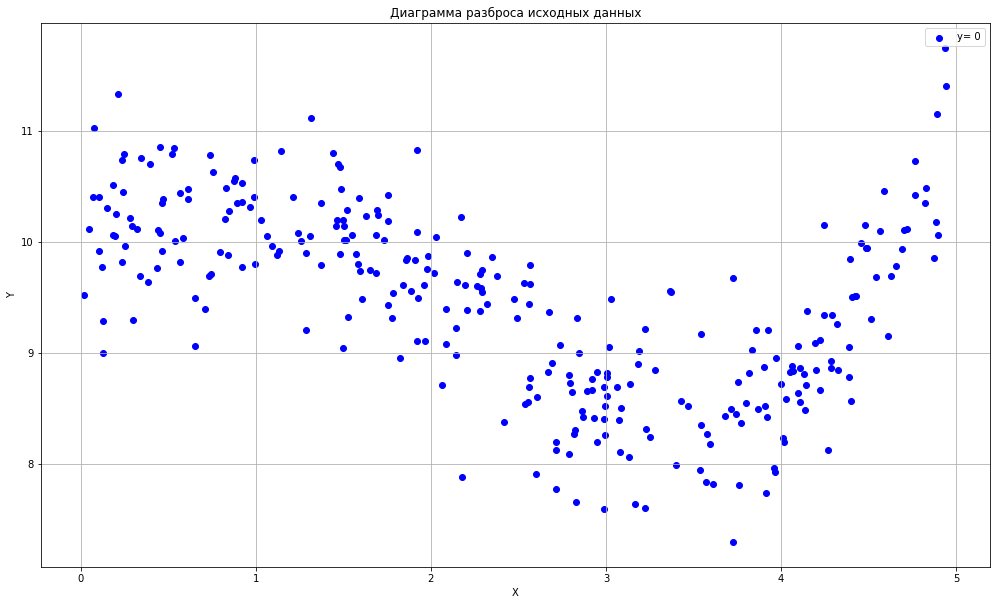

In [ ]:
plt.figure(1, figsize=[17, 10])
plt.title("Диаграмма разброса исходных данных")
plt.scatter(X1,y1, color="blue", label="y= 0")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.legend()
plt.show()


---

# Отложенная выборка

---


Cреднеквадратическая ошибка на тестовом подмножестве - 0.5684110940615401, при степени полинома - 1
Cреднеквадратическая ошибка на тестовом подмножестве - 0.46362686653006213, при степени полинома - 2
Cреднеквадратическая ошибка на тестовом подмножестве - 0.2197165422667071, при степени полинома - 3
Cреднеквадратическая ошибка на тестовом подмножестве - 0.20648820090148248, при степени полинома - 4
Cреднеквадратическая ошибка на тестовом подмножестве - 0.2130375509496698, при степени полинома - 5
Cреднеквадратическая ошибка на тестовом подмножестве - 0.21803374714019624, при степени полинома - 6
Cреднеквадратическая ошибка на тестовом подмножестве - 0.2200483973850056, при степени полинома - 7
Cреднеквадратическая ошибка на тестовом подмножестве - 0.22085029552635704, при степени полинома - 8
Cреднеквадратическая ошибка на тестовом подмножестве - 0.2212816452230775, при степени полинома - 9
Cреднеквадратическая ошибка на тестовом подмножестве - 0.22157838449220663, при степени полинома

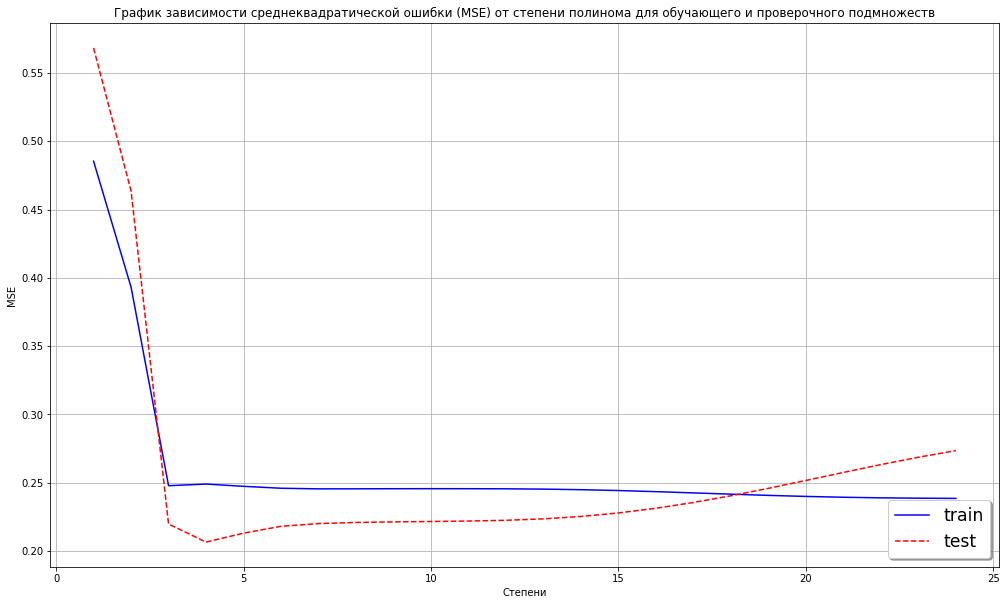

In [25]:
degrees = np.arange(1,25)
best_degree = 0
best_mse = float("inf")
scores_train=[]
scores_test=[] 
train_values = []
test_values = []
pipeline = Pipeline([
    ("transformation", PolynomialFeatures(degree=None, include_bias=False)), 
    ("stand", CustomStandardTransformer()),
    ("log_model", CustomLinearRegression())
])
for degree in degrees:
    pipeline.named_steps["transformation"].degree = degree
    hold = run_holdout(pipeline,X_train, y_train,0.7,0)
    mse_avg = hold['Test mse']    
    scores_train.append(hold['Train mse'])
    scores_test.append(hold['Test mse'])
    train_values.append(hold['Train R2'])
    test_values.append(hold['Test R2'])
    # Найти степень полинома с минимальной ошибкой на проверочном подмножестве
    if best_mse > mse_avg:
        best_mse = mse_avg
        best_degree = degree
    print('Cреднеквадратическая ошибка на тестовом подмножестве - {}, при степени полинома - {}'.format(mse_avg,degree))
print("Степень полинома :", best_degree)
plt.figure(1, figsize=[17, 10])
plt.plot(degrees, scores_train, color="blue", label = 'train')
plt.plot(degrees, scores_test, color="red", label = 'test', ls = 'dashed')
plt.xlabel("Степени")
plt.ylabel("MSE")
plt.title('График зависимости среднеквадратической ошибки (MSE) от степени полинома для обучающего и проверочного подмножеств')
plt.grid(True)
plt.legend(loc=4, shadow=True, fontsize='xx-large')
plt.show()

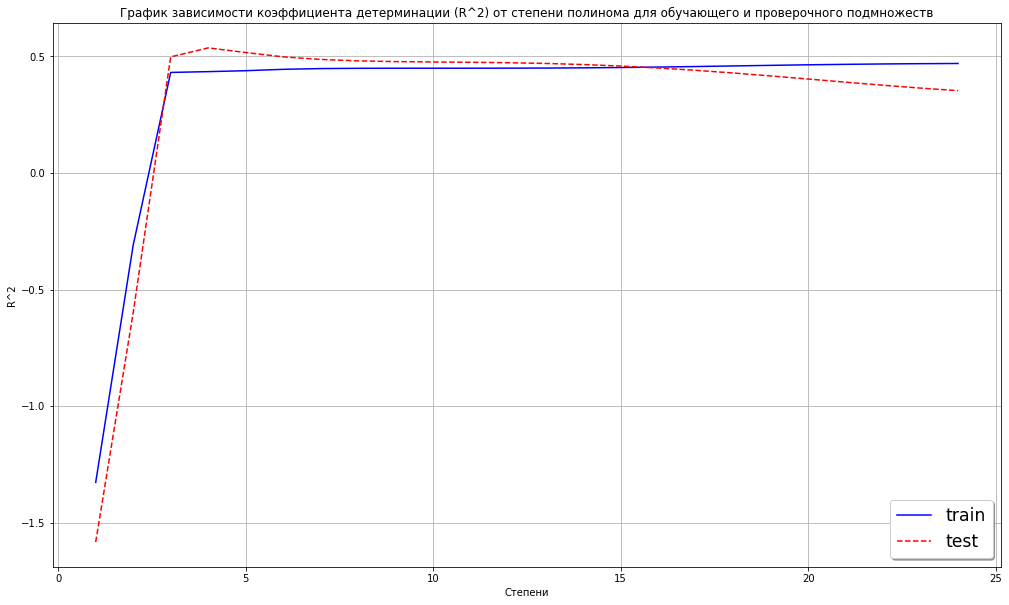

In [26]:
plt.figure(1, figsize=[17, 10])
plt.plot(degrees, train_values, color="blue", label = 'train')
plt.plot(degrees, test_values, color="red", label = 'test', ls = 'dashed')
plt.xlabel("Степени")
plt.ylabel("R^2")
plt.title('График зависимости коэффициента детерминации (R^2) от степени полинома для обучающего и проверочного подмножеств')
plt.grid(True)
plt.legend(loc=4, shadow=True, fontsize='xx-large')
plt.show()

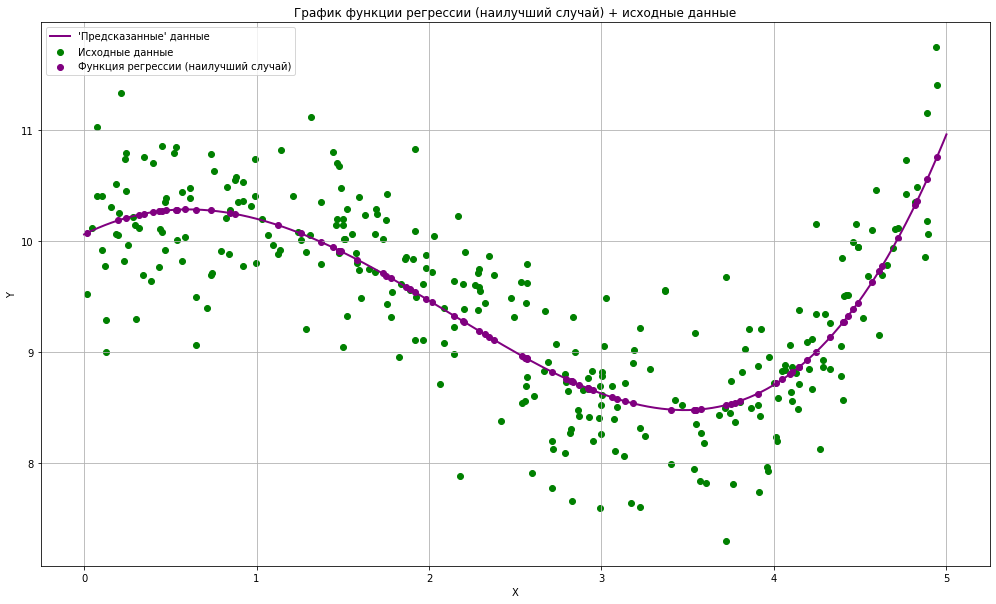

In [27]:
pipeline = Pipeline([
    ("transformation", PolynomialFeatures(degree=best_degree, include_bias=False)), 
    ("stand",  CustomStandardTransformer()),
    ("log_model", CustomLinearRegression())
])
hold = run_holdout(pipeline,X_train, y_train,0.7,0)
y_pred = pipeline.predict(X_test)
x_tr_pred = np.linspace(0, 5, 1000).reshape(-1, 1)
plt.figure("2", figsize=[17, 10])
plt.scatter(X1, y1, color="green", label="Исходные данные")
plt.scatter(X_test, y_pred[:, None], linewidth=1, color="purple", label="Функция регрессии (наилучший случай)")
plt.plot(x_tr_pred, pipeline.predict(x_tr_pred), color="purple", lw=2, label="'Предсказанные' данные")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.title("График функции регрессии (наилучший случай) + исходные данные")
plt.legend()
plt.show()

---

# Кросс-валидация

---


Cреднеквадратическая ошибка на тестовом подмножестве - 0.5139399092912563, при степени полинома - 1
Cреднеквадратическая ошибка на тестовом подмножестве - 0.4211678947764864, при степени полинома - 2
Cреднеквадратическая ошибка на тестовом подмножестве - 0.2498012095305137, при степени полинома - 3
Cреднеквадратическая ошибка на тестовом подмножестве - 0.2512757041315371, при степени полинома - 4
Cреднеквадратическая ошибка на тестовом подмножестве - 0.25667220095182064, при степени полинома - 5
Cреднеквадратическая ошибка на тестовом подмножестве - 0.2594912895044994, при степени полинома - 6
Cреднеквадратическая ошибка на тестовом подмножестве - 0.2613562271381915, при степени полинома - 7
Cреднеквадратическая ошибка на тестовом подмножестве - 0.2627524543376642, при степени полинома - 8
Cреднеквадратическая ошибка на тестовом подмножестве - 0.26353697686097377, при степени полинома - 9
Cреднеквадратическая ошибка на тестовом подмножестве - 0.2638090726123682, при степени полинома - 

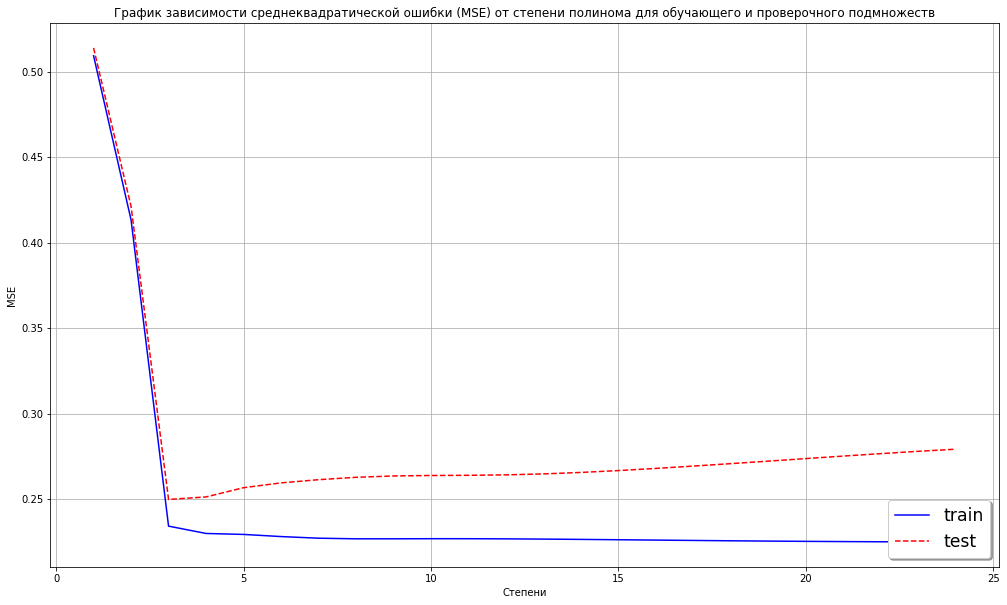

In [28]:
degrees = np.arange(1,25)
best_degree = 0
best_mse = float("inf")
scores_train=[]
scores_test=[] 
train_values = []
test_values = []
pipeline = Pipeline([
    ("transformation", PolynomialFeatures(degree=None, include_bias=False)), 
    ("stand",CustomStandardTransformer()),
    ("log_model", CustomLinearRegression())
])
for degree in degrees:
    pipeline.named_steps["transformation"].degree = degree
    hold = run_cross_val(pipeline,X_train, y_train,4, True, 0)
    mse_avg = hold['Test mse']    
    scores_train.append(hold['Train mse'])
    scores_test.append(hold['Test mse'])
    train_values.append(hold['Train R2'])
    test_values.append(hold['Test R2'])
    if best_mse > mse_avg:
        best_mse = mse_avg
        best_degree = degree
    print('Cреднеквадратическая ошибка на тестовом подмножестве - {}, при степени полинома - {}'.format(mse_avg,degree))
print("Степень полинома :", best_degree)
plt.figure(1, figsize=[17, 10])
plt.plot(degrees, scores_train, color="blue", label = 'train')
plt.plot(degrees, scores_test, color="red", label = 'test', ls = 'dashed')
plt.xlabel("Степени")
plt.ylabel("MSE")
plt.title('График зависимости среднеквадратической ошибки (MSE) от степени полинома для обучающего и проверочного подмножеств')
plt.grid(True)
plt.legend(loc=4, shadow=True, fontsize='xx-large')
plt.show()

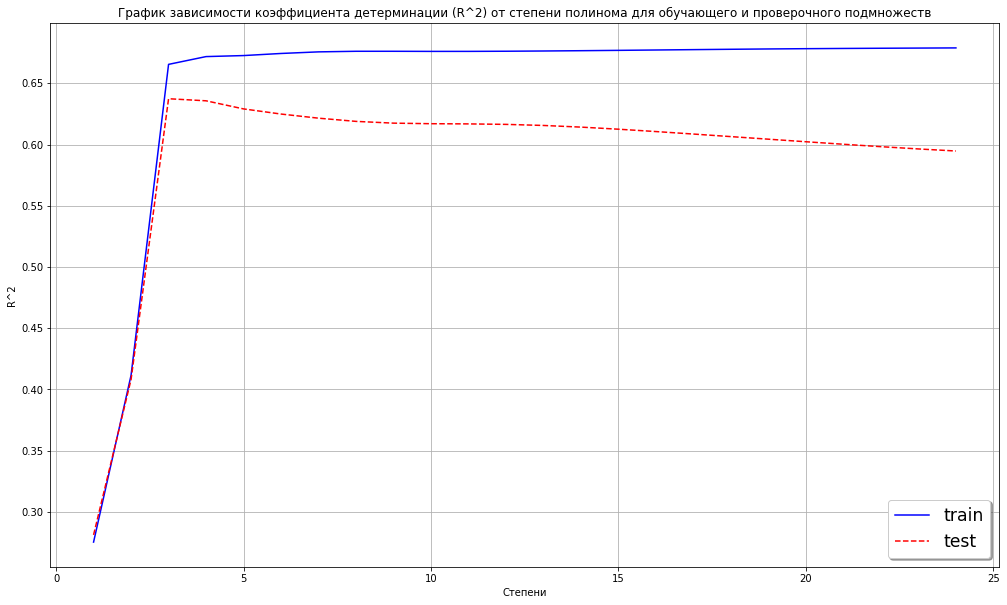

In [29]:
plt.figure(1, figsize=[17, 10])
plt.plot(degrees, train_values, color="blue", label = 'train')
plt.plot(degrees, test_values, color="red", label = 'test', ls = 'dashed')
plt.xlabel("Степени")
plt.ylabel("R^2")
plt.title('График зависимости коэффициента детерминации (R^2) от степени полинома для обучающего и проверочного подмножеств')
plt.grid(True)
plt.legend(loc=4, shadow=True, fontsize='xx-large')
plt.show()

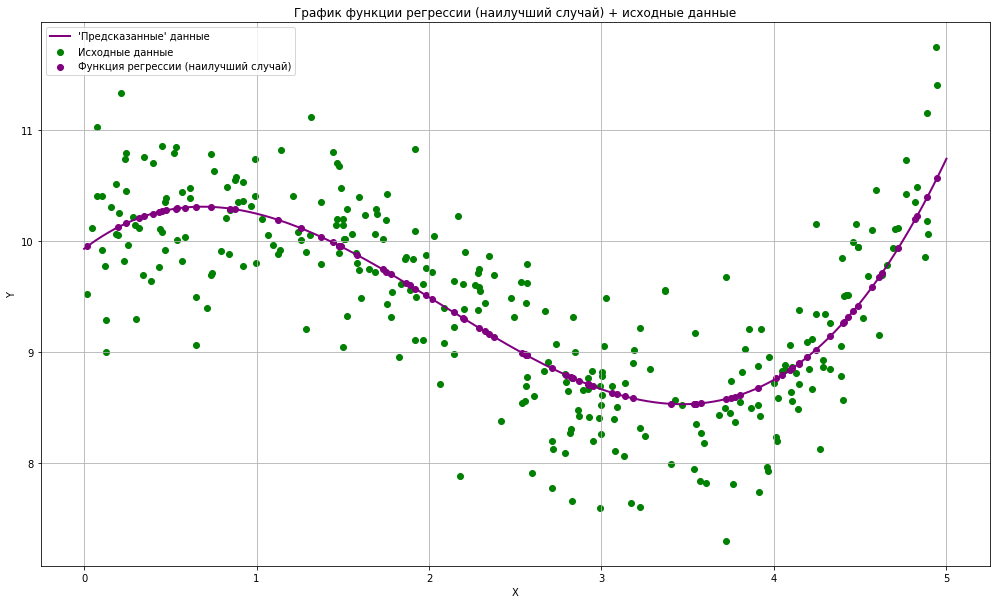

In [30]:
pipeline = Pipeline([
    ("transformation", PolynomialFeatures(degree=best_degree, include_bias=False)), 
    ("stand", CustomStandardTransformer()),
    ("log_model", CustomLinearRegression())
])
hold = run_cross_val(pipeline,X_train, y_train,4, True, 0)
y_pred = pipeline.predict(X_test)
x_tr_pred = np.linspace(0, 5, 1000).reshape(-1, 1)
plt.figure("2", figsize=[17, 10])
plt.scatter(X1, y1, color="green", label="Исходные данные")
plt.scatter(X_test, y_pred[:, None], linewidth=1, color="purple", label="Функция регрессии (наилучший случай)")
plt.plot(x_tr_pred, pipeline.predict(x_tr_pred), color="purple", lw=2, label="'Предсказанные' данные")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.title("График функции регрессии (наилучший случай) + исходные данные")
plt.legend()
plt.show()

Заключение о влиянии степени полинома регуляризации. Если степень полинома меньше степени лучшего полинома,то, при постепенном её увеличении, MSЕ постепено уменьшается, а R2 постепено увеличивается Если степень полинома больше степени лучшего полинома,то, при постепенном её увеличении, MSЕ и R2 постепено становятся стабильными

---


# Задание 3. Классификация и кросс-валидация

Набор данные:

Вариант 1
Вариант 2
⚠️ Замечание:

Используйте класс логистической регрессии из sklearn со следующими параметрами:
penalty='l2'
fit_intercept=True
max_iter=100
C=1e5
solver='liblinear'
random_state=12345
Разбейте исходные данные на обучающее и тестовое подмножества в соотношении 70 на 30, random_state=0
Для выбора гиперпараметров используйте два подхода: 1) с отложенной выборкой, 2) с кросс-валидацией
Для кросс-валидации можно использовать функцию cross_validate из sklearn
Дано множество наблюдений (см. набор данных к заданию), классификатор - логистическая регрессия. Найти степень полинома с минимальной ошибкой на проверочном подмножестве, определить долю правильных классификаций на тестовом подмножестве. Сделать заключение о влиянии степени полинома регуляризации.

Построить:

диаграмму разброса исходных данных
график зависимости доли правильных классификаций от степени полинома для обучающего и проверочного подмножеств
график зависимости доли правильных классификаций от количества итераций для обучающего и проверочного подмножеств для наилучшего случая
результат классификации для наилучшего случая (степень полинома) для обучающего и тестового подмножеств

In [31]:
data3 = pd.read_csv("https://raw.githubusercontent.com/MLMethods/Assignments/master/data/A2_Model_Selection/Cl_A5_V2.csv")
x3 = data3[['X1','X2']].values
y3 = np.reshape(data3['Y'].array,(data3['Y'].array.size,))
#Разбейте исходные данные на обучающее и тестовое подмножества в соотношении 70 на 30, random_state=0
X3_train, X3_test, y3_train, y3_test = train_test_split(x3, y3, test_size=0.3, random_state=0)


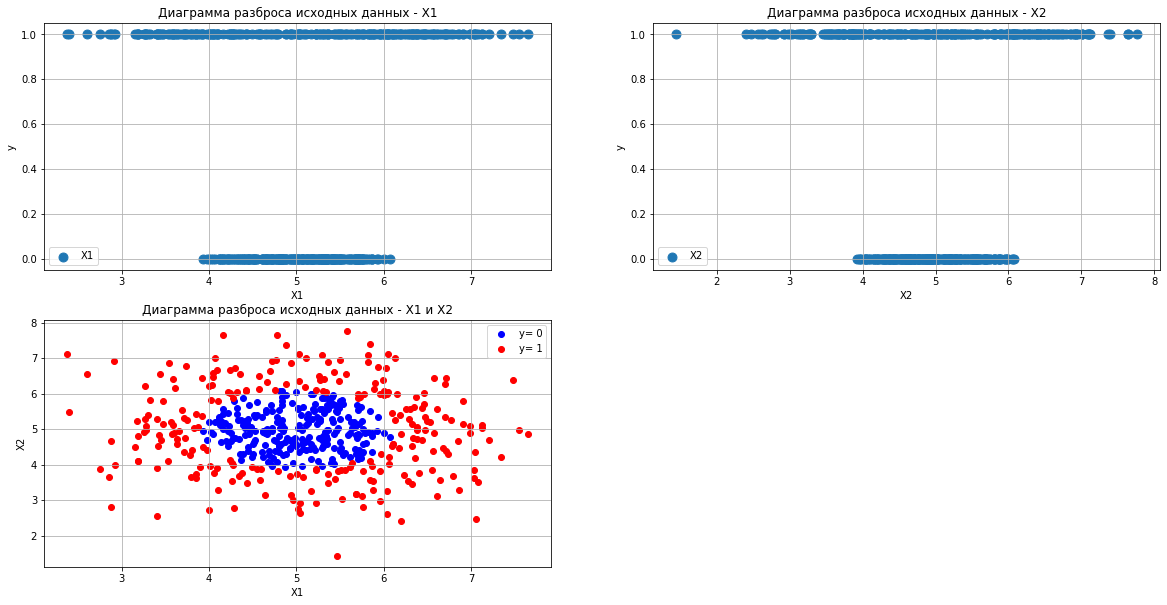

In [32]:
#Диаграмма разброса исходных данных (для Х1 и Х2)
plt.figure(1, figsize=[20, 10])
plt.subplot(2,2,1)
plt.title("Диаграмма разброса исходных данных - X1")
plt.scatter(x3[:,0], y3, s=80, label="X1")
plt.xlabel("X1")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.subplot(2,2,2)
plt.title("Диаграмма разброса исходных данных - X2")
plt.scatter(x3[:,1], y3, s=80, label="X2")
plt.xlabel("X2")
plt.ylabel("y")
plt.legend()
plt.grid(True)
y_one = np.argwhere(y3 == 1).flatten()
y_zero =  np.argwhere(y3 == 0).flatten()
plt.subplot(2,2,3)
plt.title("Диаграмма разброса исходных данных - X1 и X2")
plt.scatter(x3[y_zero][:,0], x3[y_zero][:,1], color="blue", label="y= 0")
plt.scatter(x3[y_one][:,0], x3[y_one][:,1], color="red", label="y= 1")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
'''
Используйте класс логистической регрессии из sklearn со следующими параметрами:
penalty='l2'
fit_intercept=True
max_iter=100
C=1e5
solver='liblinear'
random_state=12345
'''
logreg_model = LogisticRegression(penalty="l2", fit_intercept=True, max_iter=100, C=1e5, solver="liblinear", random_state=1234)
lm_FIT = logreg_model.fit(X3_train, y3_train)
time_logreg_model = %timeit -qo  lm_FIT
score_logreg_model = logreg_model.score(X3_test, y3_test)
print("Test Accuracy = ", score_logreg_model)
time_logreg_model

Test Accuracy =  0.5733333333333334


<TimeitResult : 10000000 loops, best of 5: 32.5 ns per loop>

---

# Отложенная выборка

---



Cреднеквадратическая ошибка на тестовом подмножестве - 0.6320754716981132, при степени полинома - 1
Cреднеквадратическая ошибка на тестовом подмножестве - 0.0, при степени полинома - 2
Cреднеквадратическая ошибка на тестовом подмножестве - 0.0, при степени полинома - 3
Cреднеквадратическая ошибка на тестовом подмножестве - 0.0, при степени полинома - 4
Cреднеквадратическая ошибка на тестовом подмножестве - 0.0, при степени полинома - 5
Cреднеквадратическая ошибка на тестовом подмножестве - 0.0, при степени полинома - 6
Cреднеквадратическая ошибка на тестовом подмножестве - 0.0, при степени полинома - 7
Cреднеквадратическая ошибка на тестовом подмножестве - 0.0, при степени полинома - 8
Cреднеквадратическая ошибка на тестовом подмножестве - 0.0, при степени полинома - 9
Cреднеквадратическая ошибка на тестовом подмножестве - 0.07547169811320754, при степени полинома - 10
Cреднеквадратическая ошибка на тестовом подмножестве - 0.09433962264150944, при степени полинома - 11
Cреднеквадратиче

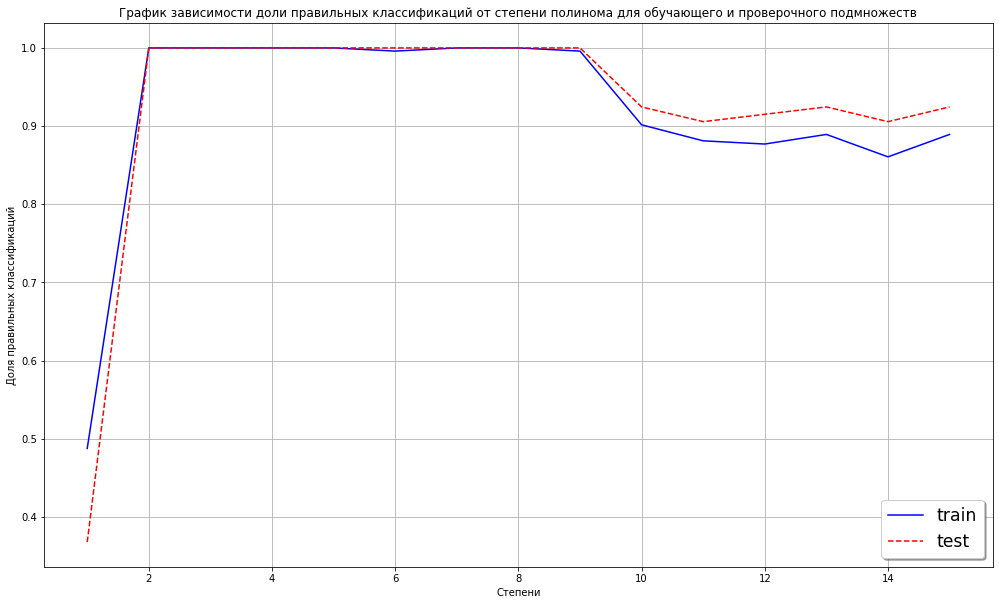

In [36]:
degrees = np.arange(1,16)
best_degree = 0
best_mse = float("inf")
scores_train=[]
scores_test=[]
pipeline = Pipeline([
    ("transformation", PolynomialFeatures(degree=None, include_bias=False)), 
    ("log_model", LogisticRegression(penalty="l2", fit_intercept=True, max_iter=100, C=1e5, solver="liblinear", random_state=1234))
])
for degree in degrees:
    pipeline.named_steps["transformation"].degree = degree
    hold = run_holdout(pipeline,X3_train, y3_train,0.7,0)
    mse_avg = hold['Test mse']    
    scores_train.append(1-hold['Train mse'])
    scores_test.append(1-hold['Test mse'])
    if best_mse > mse_avg:
        best_mse = mse_avg
        best_degree = degree
    print('Cреднеквадратическая ошибка на тестовом подмножестве - {}, при степени полинома - {}'.format(mse_avg,degree))
print("Степень полинома :", best_degree)
plt.figure(1, figsize=[17, 10])
plt.plot(degrees, scores_train, color="blue", label = 'train')
plt.plot(degrees, scores_test, color="red", label = 'test', ls = 'dashed')
plt.xlabel("Степени")
plt.ylabel("Доля правильных классификаций")
plt.title('График зависимости доли правильных классификаций от степени полинома для обучающего и проверочного подмножеств')
plt.grid(True)
plt.legend(loc=4, shadow=True, fontsize='xx-large')
plt.show()

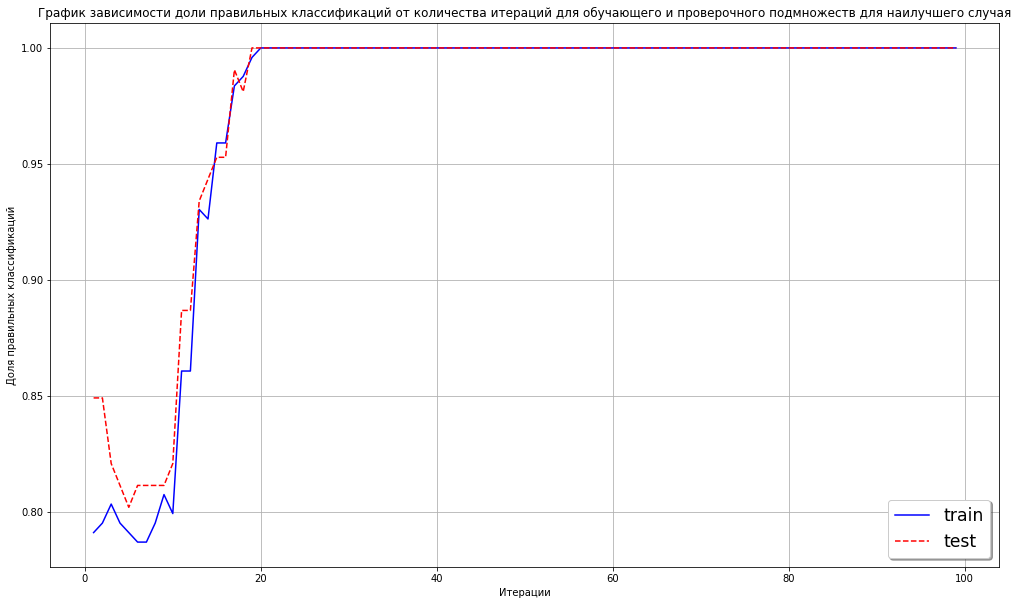

In [38]:
scores_train=[]
scores_test=[] 
pipeline = Pipeline([
    ("transformation", PolynomialFeatures(degree=best_degree, include_bias=False)), 
    ("log_model", LogisticRegression(penalty="l2", fit_intercept=True, max_iter=None, C=1e5, solver="liblinear", random_state=1234))
])
for index in range(1,100):
    pipeline.named_steps["log_model"].max_iter = index
    hold = run_holdout(pipeline,X3_train, y3_train,0.7,0)
    mse_avg = hold['Test mse']    
    scores_train.append(1-hold['Train mse'])
    scores_test.append(1-hold['Test mse'])
plt.figure(1, figsize=[17, 10])
plt.plot(range(1,100), scores_train, color="blue", label = 'train')
plt.plot(range(1,100), scores_test, color="red", label = 'test', ls = 'dashed')
plt.xlabel("Итерации")
plt.ylabel("Доля правильных классификаций")
plt.title('График зависимости доли правильных классификаций от количества итераций для обучающего и проверочного подмножеств для наилучшего случая')
plt.grid(True)
plt.legend(loc=4, shadow=True, fontsize='xx-large')
plt.show()

MSE 0.0


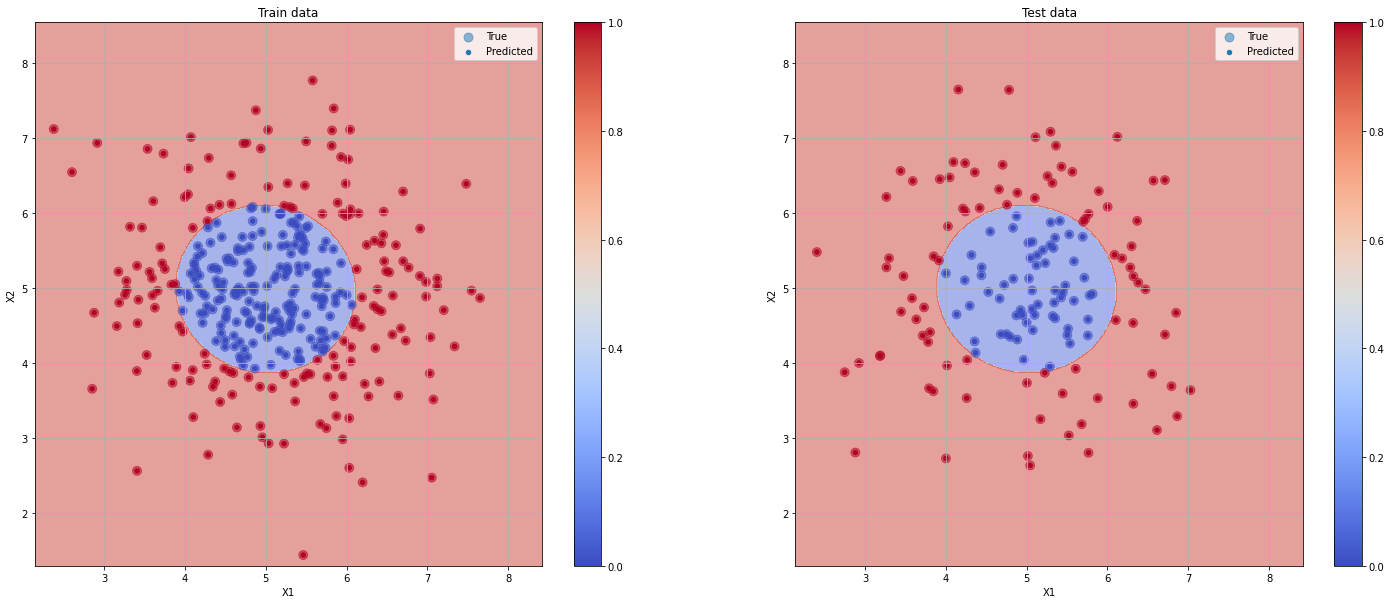

In [ ]:
plt.figure(1, figsize=[25, 10])
pipeline = Pipeline([
    ("transformation", PolynomialFeatures(degree=best_degree, include_bias=False)), 
    ("log_model", LogisticRegression(penalty="l2", fit_intercept=True, max_iter=100, C=1e5, solver="liblinear", random_state=1234))
])
pipeline.fit(X3_train,y3_train)
y_pred = pipeline.predict(X3_test)
print('MSE', mean_squared_error(y3_test,y_pred))
show_cplots(
pipeline, X3_train, y3_train, X3_test,
y3_test, title=None, cmap="coolwarm", proba=False)
plt.show()

---

# Кросс-валидация

---


Cреднеквадратическая ошибка на тестовом подмножестве - 0.6515151515151516, при степени полинома - 1
Cреднеквадратическая ошибка на тестовом подмножестве - 1.0, при степени полинома - 2
Cреднеквадратическая ошибка на тестовом подмножестве - 0.9942855276907001, при степени полинома - 3
Cреднеквадратическая ошибка на тестовом подмножестве - 1.0, при степени полинома - 4
Cреднеквадратическая ошибка на тестовом подмножестве - 1.0, при степени полинома - 5
Cреднеквадратическая ошибка на тестовом подмножестве - 1.0, при степени полинома - 6
Cреднеквадратическая ошибка на тестовом подмножестве - 1.0, при степени полинома - 7
Cреднеквадратическая ошибка на тестовом подмножестве - 0.9971264367816092, при степени полинома - 8
Cреднеквадратическая ошибка на тестовом подмножестве - 0.9943181818181818, при степени полинома - 9
Cреднеквадратическая ошибка на тестовом подмножестве - 0.9828565830721003, при степени полинома - 10
Cреднеквадратическая ошибка на тестовом подмножестве - 0.9058254963427377,

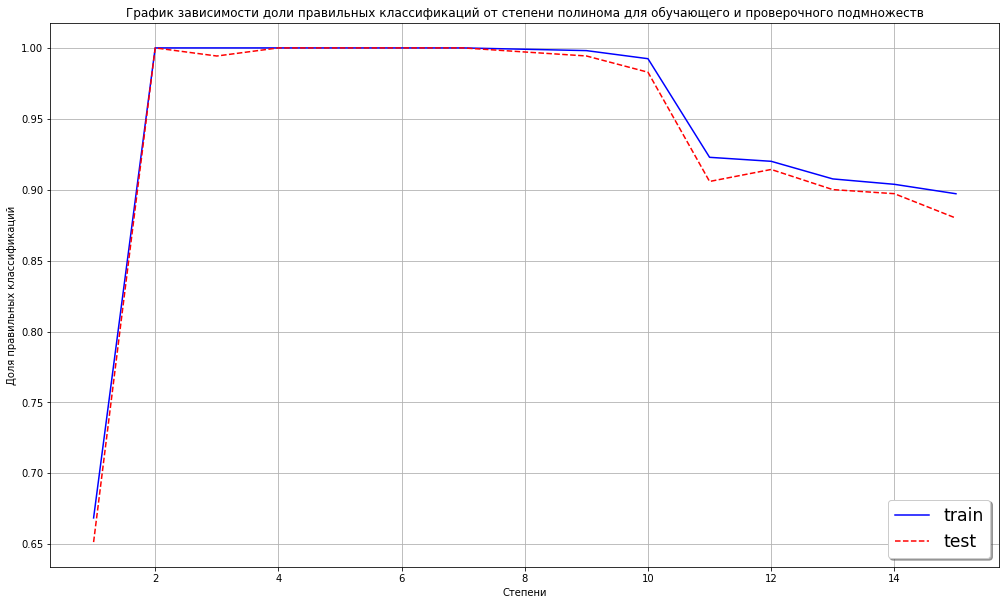

In [39]:
degrees = np.arange(1,16)
best_degree = 0
best_mse = float("inf")
scores_train=[]
scores_test=[] 
pipeline = Pipeline([
    ("transformation", PolynomialFeatures(degree=None, include_bias=False)), 
    ("log_model", LogisticRegression(penalty="l2", fit_intercept=True, max_iter=100, C=1e5, solver="liblinear", random_state=1234))
])

for degree in degrees:
    pipeline.named_steps["transformation"].degree = degree 
    scores = cross_validate(
        pipeline, X3_train, y3_train, cv=4, 
        scoring=["neg_mean_squared_error",],
        return_train_score=True
    )    
    mse_avg = 1+scores["test_neg_mean_squared_error"].mean()
    scores_train.append(1+scores["train_neg_mean_squared_error"].mean())
    scores_test.append(mse_avg)
    mse_avg_min = 1-scores["test_neg_mean_squared_error"].mean()
    if best_mse > mse_avg_min:
        best_mse = mse_avg_min
        best_degree = degree
    print('Cреднеквадратическая ошибка на тестовом подмножестве - {}, при степени полинома - {}'.format(mse_avg,degree))
print("Степень полинома :", best_degree)
plt.figure(1, figsize=[17, 10])
plt.plot(degrees, scores_train, color="blue", label = 'train')
plt.plot(degrees, scores_test, color="red", label = 'test', ls = 'dashed')
plt.xlabel("Степени")
plt.ylabel("Доля правильных классификаций")
plt.title('График зависимости доли правильных классификаций от степени полинома для обучающего и проверочного подмножеств')
plt.grid(True)
plt.legend(loc=4, shadow=True, fontsize='xx-large')
plt.show()

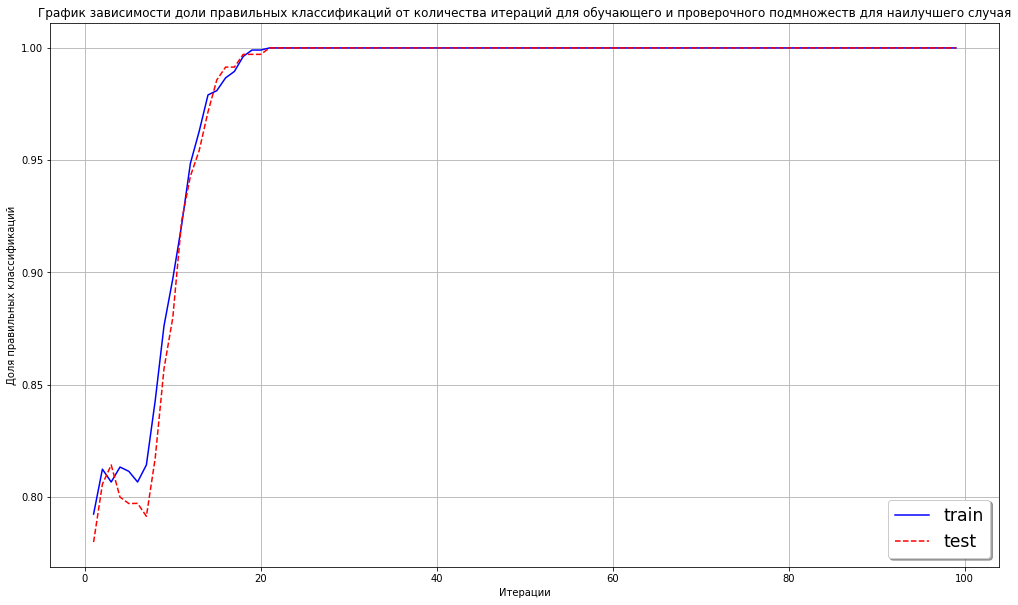

In [ ]:
scores_train=[]
scores_test=[] 
pipeline = Pipeline([
    ("transformation", PolynomialFeatures(degree=2, include_bias=False)), 
    ("log_model", LogisticRegression(penalty="l2", fit_intercept=True, max_iter=None, C=1e5, solver="liblinear", random_state=1234))
])
for index in range(1,100):
    pipeline.named_steps["log_model"].max_iter = index
    pipeline.fit(X3_train,y3_train)
    scores = cross_validate(
        pipeline, X3_train, y3_train, cv=4, 
        scoring=["neg_mean_squared_error"],
        return_train_score=True
    )
    scores_train.append(1+scores["train_neg_mean_squared_error"].mean())
    scores_test.append(1+scores["test_neg_mean_squared_error"].mean())
plt.figure(1, figsize=[17, 10])
plt.plot(range(1,100), scores_train, color="blue", label = 'train')
plt.plot(range(1,100), scores_test, color="red", label = 'test', ls = 'dashed')
plt.xlabel("Итерации")
plt.ylabel("Доля правильных классификаций")
plt.title('График зависимости доли правильных классификаций от количества итераций для обучающего и проверочного подмножеств для наилучшего случая')
plt.grid(True)
plt.legend(loc=4, shadow=True, fontsize='xx-large')
plt.show()

MSE 0.0


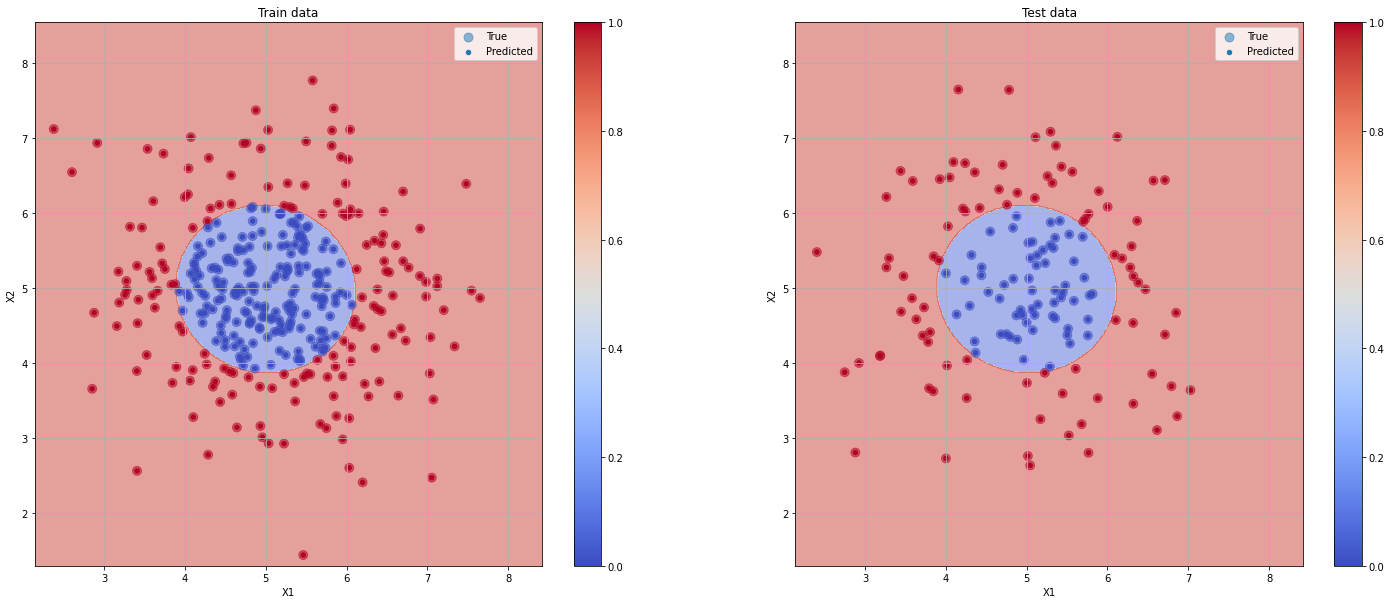

In [ ]:
plt.figure(1, figsize=[25, 10])
pipeline = Pipeline([
    ("transformation", PolynomialFeatures(degree=best_degree, include_bias=False)), 
    ("log_model", LogisticRegression(penalty="l2", fit_intercept=True, max_iter=100, C=1e5, solver="liblinear", random_state=1234))
])
pipeline.fit(X3_train,y3_train)
y_pred = pipeline.predict(X3_test)
print('MSE', mean_squared_error(y3_test,y_pred))

show_cplots(
pipeline, X3_train, y3_train, X3_test,
y3_test, title=None, cmap="coolwarm", proba=False)
plt.show()

Заключение о влиянии степени полинома регуляризации. 
Если степень полинома меньше степени лучшего полинома,то, при постепенном её увеличении, MSЕ постепено увеличивается до лучшего значения

---


#Задание 4. Регрессия и регуляризация
Набор данные

Дано множество наблюдений (см. набор данных к заданию), модель - линейная регрессия c L2 регуляризацией. Найти коэффициент регуляризации с минимальной ошибкой на проверочном подмножестве, определить среднеквадратическую ошибку на тестовом подмножестве. Для выбора гиперпараметров использовать кросс-валидацию (параметры см. задание 2). Сделать заключение о влиянии коэффициента регуляризации.

# Коэф. регуляризации
alphas = np.append([0.0], np.logspace(-8, 1, 20, base=10))
Построить:

матрицу корреляций
график зависимости среднеквадратической ошибки от коэффициента регуляризации для обучающего и проверочного подмножеств
график зависимости R-квадрата от коэффициента регуляризации для обучающего и проверочного подмножеств
график предсказанные значения (y_pred) - действительные значения (y_true) для итоговой модели

In [40]:
data4 = pd.read_csv("https://raw.githubusercontent.com/MLMethods/Assignments/master/data/A2_Model_Selection/regularization.csv")
len = data4['Y'].array.size
y4 = np.reshape(data4['Y'].array,(len,))
X4 = np.reshape(data4['X1'].array,(len,1))
for i in range(2,16):
  X4 = np.hstack((X4, np.reshape(data4['X'+str(i)].array,(len,1))))
#Разбейте исходные данные на обучающее и тестовое подмножества в соотношении 70 на 30, random_state=0
X4_train_init, X4_test, y4_train_init, y4_test = train_test_split(X4, y4, test_size=0.3, random_state=0)
X4_train,X4_val, y4_train, y4_val = train_test_split(X4_train_init, y4_train_init, test_size=0.3, random_state=0)
REGULARIZATION = 0
POLY_DEGREE = 16

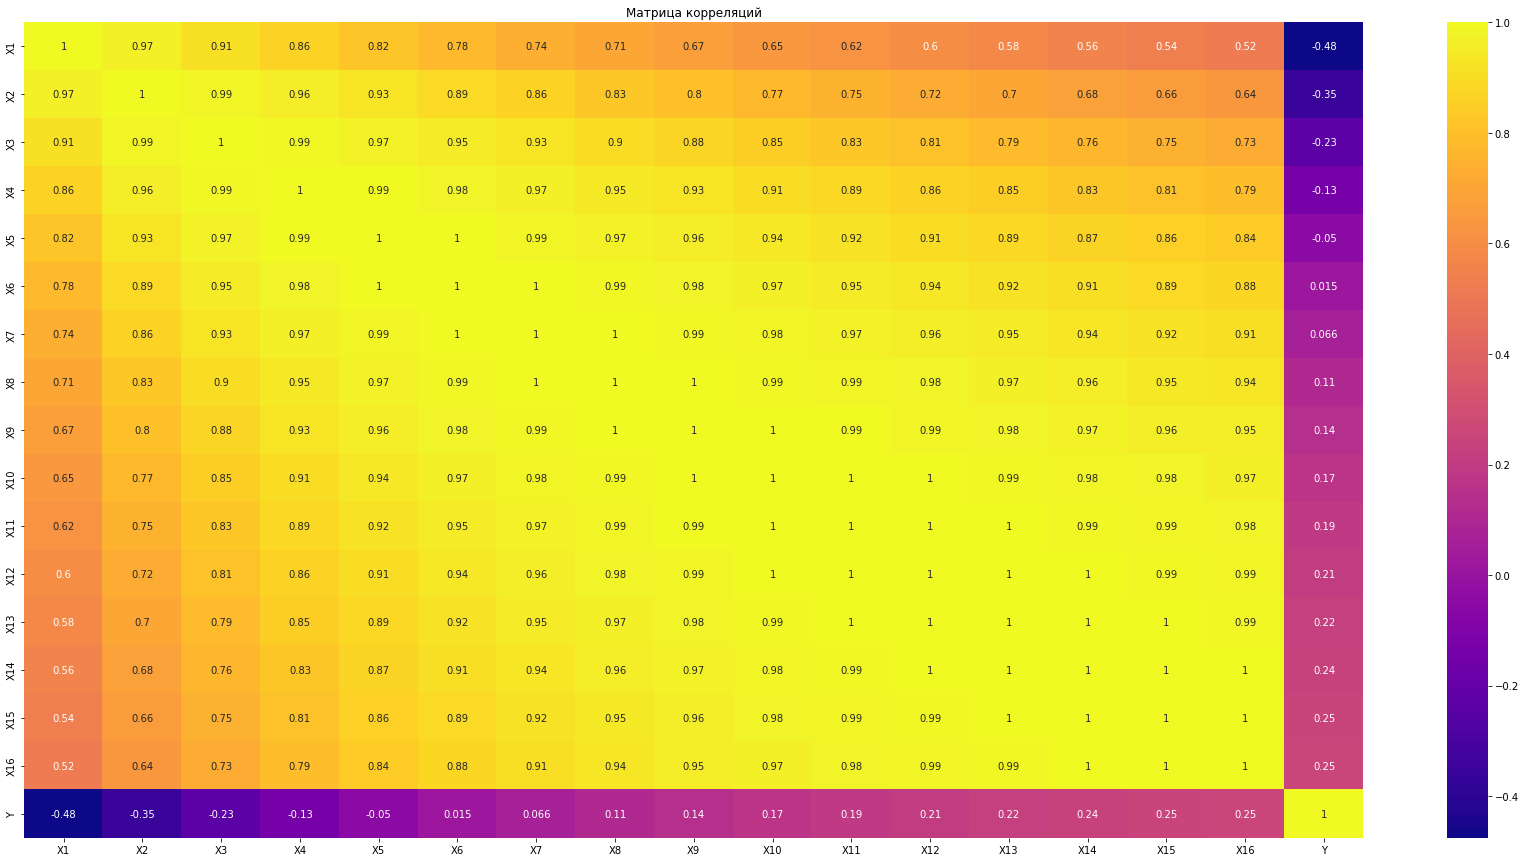

In [41]:
#Матрица корреляций
import seaborn as sn
corr_matrix = data4.corr()
plt.figure("2/2",figsize=[30, 15])
plt.title("Матрица корреляций")
sn.heatmap(corr_matrix, annot=True,cmap="plasma")
plt.show()

Коэффициент регуляризации с минимальной ошибкой на проверочном подмножестве - 7.847599703514607e-07; MSE 0.2730954157543857


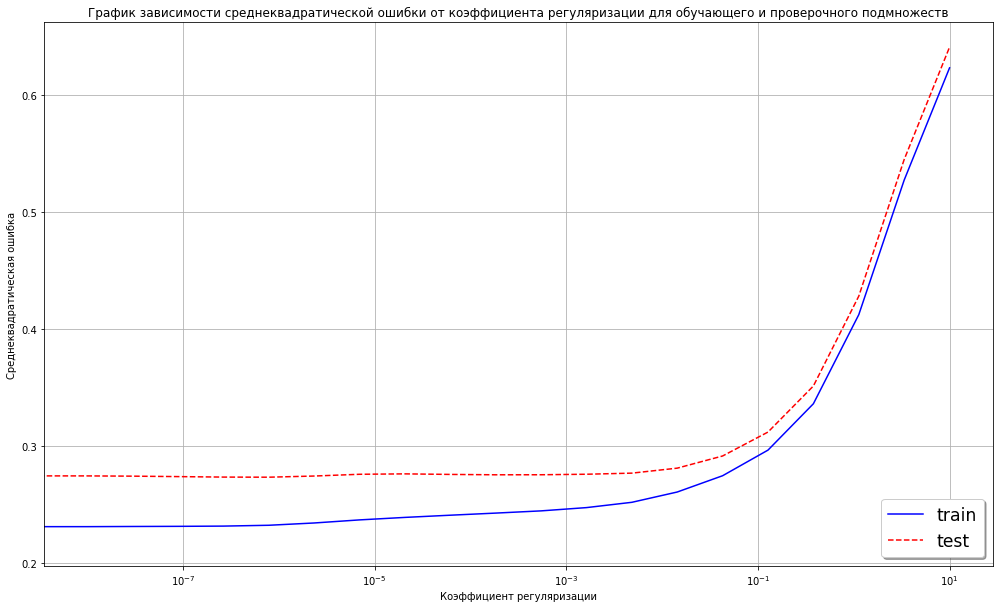

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

ridge_model =  Ridge(alpha=None,fit_intercept=True, normalize=True)

alphas = np.append([0.0], np.logspace(-8, 1, 20, base=10))
best_alpha = alphas[0]
best_mse = 1e10
scores_train=[]
scores_test=[] 
train_values = []
test_values = []
for alpha in alphas:
    ridge_model.alpha=alpha
    ridge_model.fit(X4_train, y4_train)
    scores = cross_validate(
        ridge_model, X4_train, y4_train, cv=4, 
        scoring=["neg_mean_squared_error",'r2'],
        return_train_score=True
    )    
    mse_avg = -scores["test_neg_mean_squared_error"].mean()
    scores_train.append(-scores["train_neg_mean_squared_error"].mean())
    scores_test.append(-scores["test_neg_mean_squared_error"].mean())
    mse_avg_min = -scores["test_neg_mean_squared_error"].mean()   


    train_values.append( scores["train_r2"].mean())
    test_values.append( scores["test_r2"].mean())
    # Найти коэффициент регуляризации с минимальной ошибкой на проверочном подмножестве
    if best_mse > mse_avg_min:
        best_mse = mse_avg_min
        best_alpha = alpha
print("Коэффициент регуляризации с минимальной ошибкой на проверочном подмножестве - {}; MSE {}".format(best_alpha, best_mse))
plt.figure(1, figsize=[17, 10])
plt.plot(alphas, scores_train, color="blue", label = 'train')
plt.plot(alphas,  scores_test, color="red", label = 'test', ls = 'dashed')
plt.xlabel("Коэффициент регуляризации")
plt.ylabel("Cреднеквадратическая ошибка")
plt.title('График зависимости среднеквадратической ошибки от коэффициента регуляризации для обучающего и проверочного подмножеств')
plt.xscale('log')
plt.grid(True)
plt.legend(loc=4, shadow=True, fontsize='xx-large')
plt.show()

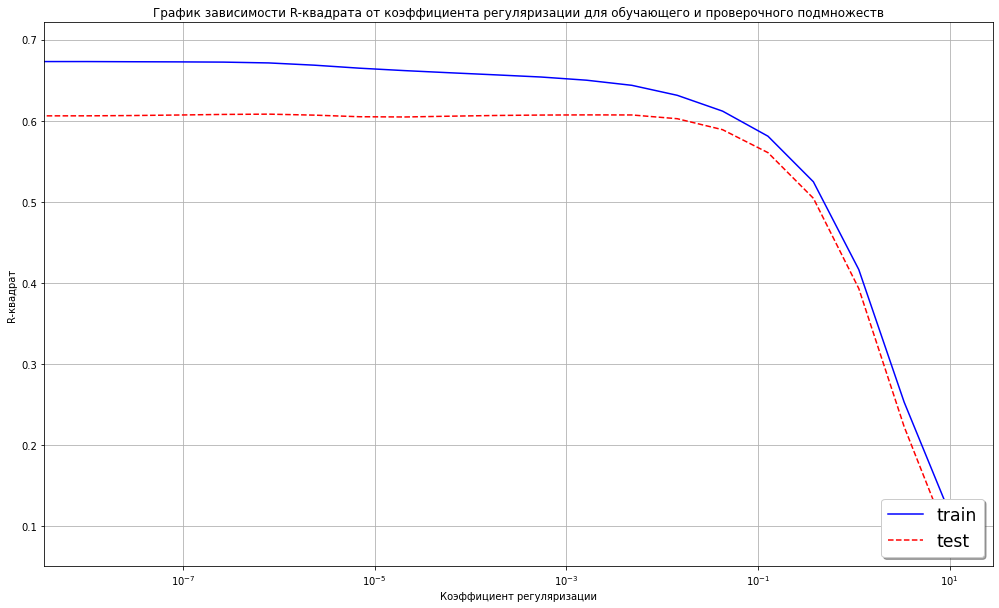

In [ ]:
plt.figure(1, figsize=[17, 10])
plt.plot(alphas, train_values, color="blue", label = 'train')
plt.plot(alphas, test_values, color="red", label = 'test', ls = 'dashed')
plt.xlabel("Коэффициент регуляризации")
plt.ylabel("R-квадрат")
plt.title('График зависимости R-квадрата от коэффициента регуляризации для обучающего и проверочного подмножеств')
plt.grid(True)
plt.xscale('log')

plt.legend(loc=4, shadow=True, fontsize='xx-large')
plt.show()

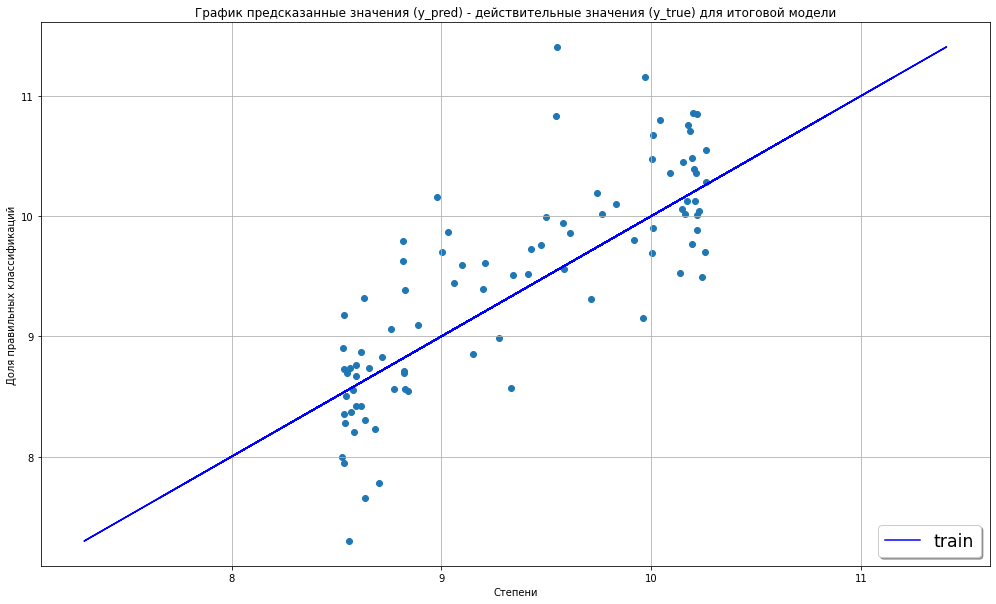

In [ ]:
#График предсказанные значения (y_pred) - действительные значения (y_true) для итоговой модели
ridge_model = Ridge(alpha=best_alpha,fit_intercept=True, normalize=True)
ridge_model.fit(X4_train, y4_train)
plt.figure(1, figsize=[17, 10])
plt.scatter(ridge_model.predict(X4_test), y4_test)
plt.plot(y4_test, y4_test, color="blue", label = 'train')
plt.xlabel("Степени")
plt.ylabel("Доля правильных классификаций")
plt.title('График предсказанные значения (y_pred) - действительные значения (y_true) для итоговой модели')
plt.grid(True)
plt.legend(loc=4, shadow=True, fontsize='xx-large')
plt.show()

Вывод о влиянии коэффициента регуляризации.

При увеличении alpha, MSE постепенно возрастет
